In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as psc

In [3]:
#Creamos las credenciales para ingresar a la base de datos
from sqlalchemy import create_engine
server = {
    'user' : 'postgres',
    'password' : 'detectivecreador',
    'host' : 'localhost',
    'port' : '5434',
    'database' : 'SITEC, soluciones y servicios'
}

#Creamos la cadena de conexión
#conn_str = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'

conn_str = f"postgresql+psycopg2://{server['user']}:{server['password']}@{server['host']}:{server['port']}/{server['database']}"

#Creamos el motor de conexión

engine = create_engine(conn_str)

In [4]:
#Extraemos la tabla compras
#Tenemos que castear la columna importe total ya que esta en formato money y al extraerlo y guardarlo en un dataframe, el tipo
#de columna será tipo str
consulta = '''SELECT id_compra, 
            id_proveedor, 
            id_estado, status, 
            ref_proveedor, 
            fecha_recepcion AS fecha, 
            fecha_cancelacion,
            CAST(importe_total AS numeric) AS importe_total FROM compras'''

compras = pd.read_sql(consulta,engine)


In [5]:
#Revisamos las variables estadisticas del dataframe
compras.describe()

 

,id_compra,id_proveedor,id_estado,importe_total
count,9910.000000,9910.000000,9910.000000,9.910000e+03
mean,4955.500000,688.875177,1.617154,1.848554e+04
std,2860.914918,392.101356,0.713287,8.533682e+04
min,1.000000,1.000000,1.000000,7.840000e+00
25%,2478.250000,422.000000,1.000000,5.370275e+02
50%,4955.500000,727.000000,1.000000,1.776625e+03
75%,7432.750000,935.000000,2.000000,1.102000e+04
max,9910.000000,14001.000000,3.000000,5.271941e+06


Si queremos realizar queries dentro de un dataframe, tenemos que importar la libreria *pandassql*:

**pip install pandasql**



In [6]:
import pandasql as ps

#Definimos la query

consulta = '''SELECT importe_total FROM compras'''

print(ps.sqldf(consulta,locals())) #la función .sqldf nos permite realizar una consulta (primer argumento) a los dataframes locales
#la tabla que va a tomar es la que viene en la querie, detectará ese nombre y buscara en el area local un dataframe con ese nombre

      importe_total
0            449.00
1            393.18
2            180.00
3           4505.93
4            123.00
...             ...
9905       12819.70
9906         301.00
9907       38860.00
9908        7984.59
9909       29997.38

[9910 rows x 1 columns]


In [7]:
#Extraemos las tablas que existen en la base de datos.
qproveedores = 'SELECT * FROM proveedores'
proveedores = pd.read_sql(qproveedores,engine)


In [8]:
##Obtener los 3 mejores proveedores por mes del 2024
enero = '''SELECT DISTINCT(p.nombre), SUM(c.importe_total) AS importe__proveedor FROM compras c
        INNER JOIN proveedores p
        ON c.id_proveedor = p.id_proveedor
        WHERE fecha BETWEEN '2024-01-01T00:00:00.000Z' AND '2024-01-31T00:00:00.000Z'
        GROUP BY p.nombre
        ORDER BY SUM(c.importe_total) DESC
        LIMIT 3
        '''
febrero = '''SELECT DISTINCT(p.nombre), SUM(c.importe_total) AS importe__proveedor FROM compras c
        INNER JOIN proveedores p
        ON c.id_proveedor = p.id_proveedor
        WHERE fecha BETWEEN '2024-02-01T00:00:00.000Z' AND '2024-02-31T00:00:00.000Z'
        GROUP BY p.nombre
        ORDER BY SUM(c.importe_total) DESC
        LIMIT 3
        '''
marzo = '''SELECT DISTINCT(p.nombre), SUM(c.importe_total) AS importe__proveedor FROM compras c
        INNER JOIN proveedores p
        ON c.id_proveedor = p.id_proveedor
        WHERE fecha BETWEEN '2024-03-01T00:00:00.000Z' AND '2024-03-31T00:00:00.000Z'
        GROUP BY p.nombre
        ORDER BY SUM(c.importe_total) DESC
        LIMIT 3
        '''
abril = '''SELECT DISTINCT(p.nombre), SUM(c.importe_total) AS importe__proveedor FROM compras c
        INNER JOIN proveedores p
        ON c.id_proveedor = p.id_proveedor
        WHERE fecha BETWEEN '2024-04-01T00:00:00.000Z' AND '2024-04-31T00:00:00.000Z'
        GROUP BY p.nombre
        ORDER BY SUM(c.importe_total) DESC
        LIMIT 3
        '''
mayo = '''SELECT DISTINCT(p.nombre), SUM(c.importe_total) AS importe__proveedor FROM compras c
        INNER JOIN proveedores p
        ON c.id_proveedor = p.id_proveedor
        WHERE fecha BETWEEN '2024-05-01T00:00:00.000Z' AND '2024-05-31T00:00:00.000Z'
        GROUP BY p.nombre
        ORDER BY SUM(c.importe_total) DESC
        LIMIT 3
        '''

meses = ['enero','febrero','marzo','abril','mayo']
q = [ps.sqldf(enero,locals()),ps.sqldf(febrero,locals()),ps.sqldf(marzo,locals()),ps.sqldf(abril,locals()),ps.sqldf(mayo,locals())]


In [9]:
rankingproveedores2024 = {}
rankingproveedores2024 = {mes : consulta for mes,consulta in zip(meses,q)}

In [10]:
rankingproveedores2024['febrero']

,nombre,importe__proveedor
0,DISTRIBUIDORA DE MAT. ELECTRICOS IND. DE TOLUC...,590173.58
1,"Zigor Soluciones Integrales, S.A. de C.V.",509356.06
2,"Productos Eléctricos y Ferreteros, S.A. de C.V...",243632.83


In [11]:
# %, cantidad de compras por almacen mensuales


qestados = '''SELECT * FROM estados'''
estados = pd.read_sql(qestados, engine)

q = '''SELECT  e.estado, 
               SUM(c.importe_total)/(SELECT SUM(importe_total) FROM compras WHERE fecha BETWEEN '2024-05-01T00:00:00.000Z' AND '2024-05-31T00:00:00.000Z') AS porcentaje, 
               SUM(c.importe_total) AS importe_por_estado FROM compras c
        INNER JOIN estados e
        ON c.id_estado = e.id_estado
        WHERE fecha BETWEEN '2024-05-01T00:00:00.000Z' AND '2024-05-31T00:00:00.000Z'           --Mayo
        GROUP BY e.estado
        ORDER BY importe_por_estado DESC'''


print(ps.sqldf(q,locals()))

            estado  porcentaje  importe_por_estado
0        Queretaro    0.978747          4232307.98
1  San Luis Potosi    0.019646            84951.76
2       Guanajuato    0.001608             6952.00


In [12]:
# corroborar las relación entre cancelación y status, tienen que empatar

q_can_stat = '''SELECT status, fecha_cancelacion FROM compras
                WHERE status = 'Cancelada' AND fecha_cancelacion IS NULL '''
                
print(ps.sqldf(q_can_stat,locals()))               

#Si existe correlación 

Empty DataFrame
Columns: [status, fecha_cancelacion]
Index: []


In [13]:
#Porcentaje de canceladas
q_can = """SELECT status,COUNT(status) AS cantidad, CAST(COUNT(status) AS float)*100/(SELECT COUNT(*) FROM compras) AS percent FROM compras
            GROUP BY status"""          #Es necesario castear la operacion aritmetica ya sea multiplicando por un flotannte
                                        #utilizando :: o CAST()
print(ps.sqldf(q_can,locals()))    

#Otro ejemplo:       
# SELECT status, 
#                   COUNT(status) AS cantidad, 
#                   (COUNT(status) * 100.0 / total.total_count) AS porcentaje_por_concepto
# FROM 
#     compras,(SELECT COUNT(*) AS total_count FROM compras) AS total
# GROUP BY 
#     status, total.total_count


      status  cantidad    percent
0  Cancelada       474   4.783047
1    Emitida       238   2.401615
2   Original      9198  92.815338


# Gráficas

utilizaremos tanto **matplotlib** como **seaborn** dependiendo de la necesidad y la estética

In [27]:
#Graficamos los 3 mejores proveedores en un periodo de 6 meses y un periodo anual
#Extraemos una tabla unicamente con la información necesaria y agregamos dos columnas, una para el mes y otra para el año

q_prov = '''
SELECT 
    p.nombre,
    TO_CHAR(c.fecha_recepcion, 'Month') AS mes,
    TO_CHAR(c.fecha_recepcion, 'YYYY') AS año,
    CAST(c.importe_total AS numeric) AS "importe total"
FROM 
    compras c
INNER JOIN 
    proveedores p ON c.id_proveedor = p.id_proveedor;

                
                '''
prov = pd.read_sql(q_prov,engine)

 
prov

#fig, ax = plt.subplots()
#ax.scatter(x[])      

,nombre,mes,año,importe total
0,"RADIOMOVIL DIPSA, S.A. DE C.V. - TELCEL",April,2019,449.00
1,VALVULAS Y CONEXIONES INDUSTRIALES S.A. DE C.V...,February,2020,393.18
2,COMERCIALIZADORA DE MATERIAL ELECTRICO Y HERRA...,February,2020,180.00
3,MARTHA ALICIA GARCIA DELGADO - FERREMAX SLP,February,2020,4505.93
4,ENRIQUE JUVENTINO MORLET AVILA - ACEROS MORLET,February,2020,123.00
...,...,...,...,...
9905,TECNO ELECTRICA POTOSI SA DE CV,June,2024,12819.70
9906,RAQUEL ARVIZU FEREGRINO-FERREMATERIALES EL PUERTO,June,2024,301.00
9907,Luis Manuel Olguin Ballesteros - Renta platafo...,June,2024,38860.00
9908,"CLIMAPROYECTOS, S.A. DE C.V.",June,2024,7984.59


In [15]:
prov_por_año = { '2020' : prov[prov['año'] == '2020'],
                '2021' : prov[prov['año'] == '2021'],
                '2022' : prov[prov['año'] == '2022'],
                '2023' : prov[prov['año'] == '2023'],
                '2024' : prov[prov['año'] == '2024']}




In [ ]:
#Primero obtendremos datos significativos para luego representarlos gráficamente
total_compras_por_año = [0.0,0.0,0.0,0.0,0.0]

for i in range(len(prov)):
    if prov['año'][i] == '2020': 
        #print(prov['año'][i])
        total_compras_por_año[0] += prov['importe total'][i] 
    elif prov['año'][i] == '2021': 
        for i in range(len(prov)):
            total_compras_por_año[1] += prov['importe total'][i] 
    elif prov['año'][i] == '2022': 
        for i in range(len(prov)):
            total_compras_por_año[2] += prov['importe total'][i] 
    elif prov['año'][i] == '2023': 
        for i in range(len(prov)):
            total_compras_por_año[3] += prov['importe total'][i] 
    else: 
        for i in range(len(prov)):
            total_compras_por_año[4] += prov['importe total'][i] 

total_compras_por_año[0]
#utilizaremos otro metodo para realizar el procedimiento que sea mas óptimo sin necesidad de tanto procesamiento


total_compras_por_año = pd.groupby('año')[imp]

In [61]:
print(pd.groupby('año')['importe '])

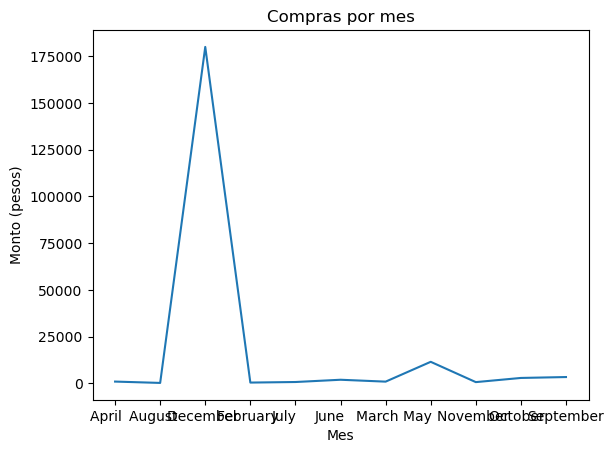

In [17]:
#vamos a trabajar con el año 2020

#REALIZAREMOS VARIOS GRÁFICOS PARA DOMINAR LAS GRÁFICAS Y REPRESENTACIONES DE DATOS.

y2020 = prov_por_año['2020']
q2020 = '''SELECT mes, importe_total AS 'importe total' FROM y2020 GROUP BY mes'''
y2020 = ps.sqldf(q2020,locals())

x = y2020['mes']
y = y2020['importe total']



plt.plot(x,y)
plt.xlabel("Mes")
plt.ylabel("Monto (pesos)")
plt.title("Compras por mes")
plt.show()

# fig, ax = plt.subplots()
# ax.hist(y2020['mes'])


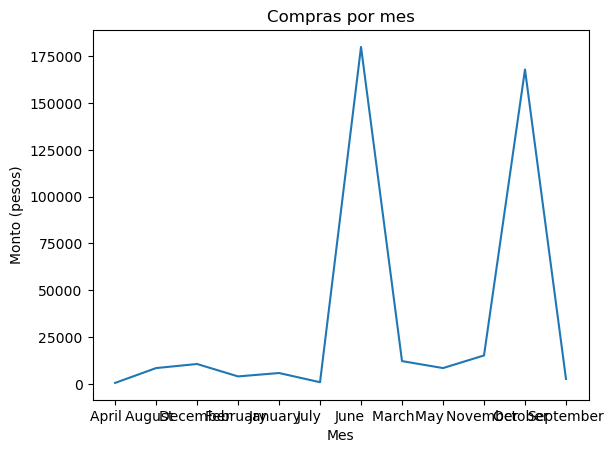

In [18]:
y2021 = prov_por_año['2021']
q2021 = '''SELECT mes, importe_total AS 'importe total' FROM y2021 GROUP BY mes'''
y2021 = ps.sqldf(q2021,locals())

plt.plot(y2021['mes'],y2021['importe total'])
plt.xlabel("Mes")
plt.ylabel("Monto (pesos)")
plt.title("Compras por mes")
plt.show()

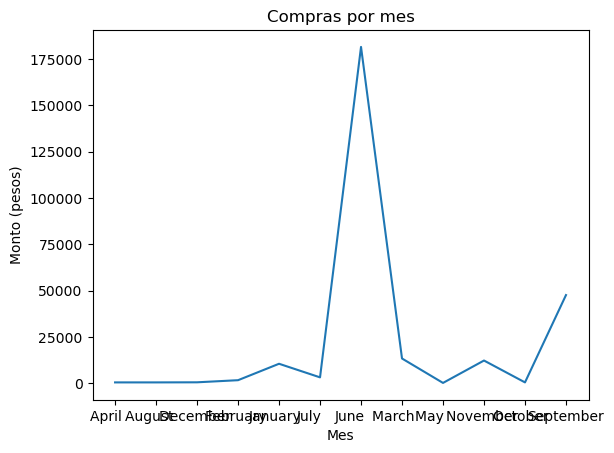

In [19]:
y2022 = prov_por_año['2022']
q2022 = '''SELECT mes, importe_total AS 'importe total' FROM y2022 GROUP BY mes'''
y2022= ps.sqldf(q2022,locals())

plt.plot(y2022['mes'],y2022['importe total'])
plt.xlabel("Mes")
plt.ylabel("Monto (pesos)")
plt.title("Compras por mes")
plt.show()

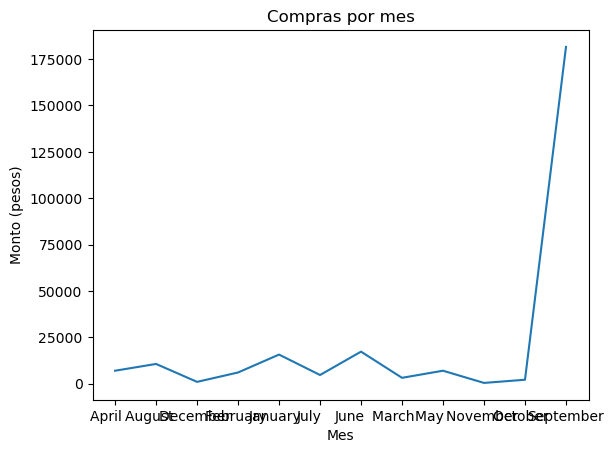

In [20]:
y2023 = prov_por_año['2023']
q2023 = '''SELECT mes, importe_total AS 'importe total' FROM y2023 GROUP BY mes'''
y2023 = ps.sqldf(q2023,locals())

plt.plot(y2023['mes'],y2023['importe total'])
plt.xlabel("Mes")
plt.ylabel("Monto (pesos)")
plt.title("Compras por mes")
plt.show()



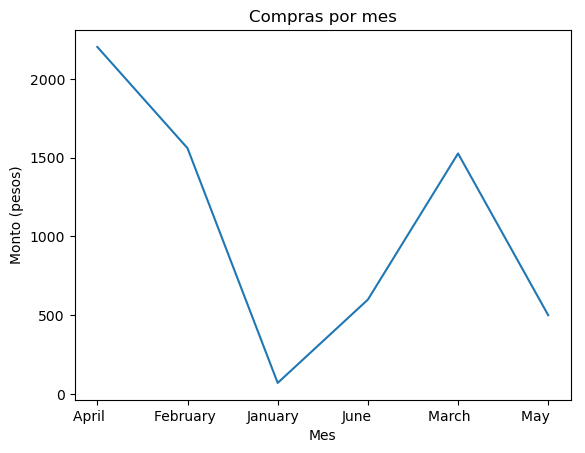

In [21]:
y2024 = prov_por_año['2024']
q2024 = '''SELECT mes, importe_total AS 'importe total' FROM y2024 GROUP BY mes'''
y2024= ps.sqldf(q2024,locals())

plt.plot(y2024['mes'],y2024['importe total'])
plt.xlabel("Mes")
plt.ylabel("Monto (pesos)")
plt.title("Compras por mes")
plt.show()